# 1. Понимание бизнеса

## 1.1 Цель
Целью задачи является прогнозирование качества вина по его физико-химическим свойствам

## 1.2 Описание

Вино - это алкогольный напиток, приготовленный из ферментированного винограда. Дрожжи потребляют сахар из винограда и превращают его в этанол, углекислый газ и тепло. Это приятный на вкус алкогольный напиток, очень любимый целебратом . Безусловно, будет интересно проанализировать физико-химические свойства вина и понять их взаимосвязь и значимость с классификацией качества и типов вина. 
Набор данных относится к красному и белому вариантам вина "Виньо Верде". Vinho verde-это уникальный продукт из региона Минью (Северо-Запад) Португалии. Средний по спирту, он особенно ценится благодаря своей свежести (особенно летом). Этот набор данных является общедоступным только для исследовательских целей, для получения дополнительной информации см. Cortez et al., 2009. . Из-за проблем конфиденциальности и логистики доступны только физико-химические (входные данные) и сенсорные (выходные данные) переменные (например, нет данных о типах винограда, марке вина, цене продажи вина и т. д.).

атрибутивная информация:

Входные переменные (на основе физико-химических тестов): 1-фиксированная кислотность 2-Летучая кислотность 3-лимонная кислота 4-остаточный сахар 5-хлориды 6-свободный диоксид серы 7-общий диоксид серы 8-Плотность 9-рН 10-сульфаты 11-выходная переменная спирта (на основе сенсорных данных): 12-качество (оценка от 0 до 10)

Заметки UCI о наборе данных:

Классы упорядочены и не сбалансированы (например, есть Мунк больше нормальных вин, чем отличных или плохих).
Для обнаружения нескольких превосходных или плохих вин можно было бы использовать более сложные алгоритмы обнаружения выбросов.
Кроме того, мы не уверены, что все входные переменные релевантны. Поэтому было бы интересно протестировать методы выбора функций.

# 2. Data Understanding

## 2.1 Import Libraries


In [2]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import numpy as np
import pandas as pd
import pylab 
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
%matplotlib inline
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
#from graphviz import Source
from IPython.display import Image

from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from scipy import interp
from sklearn.base import BaseEstimator, TransformerMixin, clone, ClassifierMixin
from sklearn import metrics, tree
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler, PolynomialFeatures, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score

from sklearn.linear_model import LogisticRegression
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from mlxtend.classifier import StackingClassifier

#from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
#from skater.core.explanations import Interpretation
#from skater.model import InMemoryModel

## 2.2 Вспомогательные функции

In [3]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

## 2.3 Загрузка данных

In [10]:
import os 
os.chdir ('E://Netology/DS')
wines = pd.read_csv('winequalityN.csv')

## 2.4 Статистика и визуализации

In [11]:
wines.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**Описание переменных**
type - типа вина
fixed acidity - фиксированная кислотность
volatile acidity -Летучая кислотность
citric acid -лимонная кислота
residual sugar-остаточный сахар
chlorides-хлориды
free sulfur dioxide-свободный диоксид серы
total sulfur dioxide-общий диоксид серы
density-Плотность
рН - мера кислотности
sulphates-сульфаты
alcohol-алкоголь
Целевой признак:
quality-качество (оценка от 0 до 10 баллов)

### 2.4.1 Ключевая информация о переменных


In [13]:
wines.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [ ]:
# residual sugar и free sulfur dioxide надо изучить на выбросы

In [10]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
type                    6497 non-null object
fixed acidity           6487 non-null float64
volatile acidity        6489 non-null float64
citric acid             6494 non-null float64
residual sugar          6495 non-null float64
chlorides               6495 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6488 non-null float64
sulphates               6493 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 659.9+ KB


In [ ]:
# В датасете есть категориальная переменная и есть пропуски

### 2.4.2 Преобразование целевого признака

In [12]:
wines['quality_label'] = wines.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')

### 2.4.3 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

In [ ]:
sns.heatmap(wines.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

In [ ]:
# Хичисеские свойства вина сильно зависят от типа вина (бело-красное). В остальных признаках нет сильной корреляции

### 2.4.4 Взаимосвязь между признаками


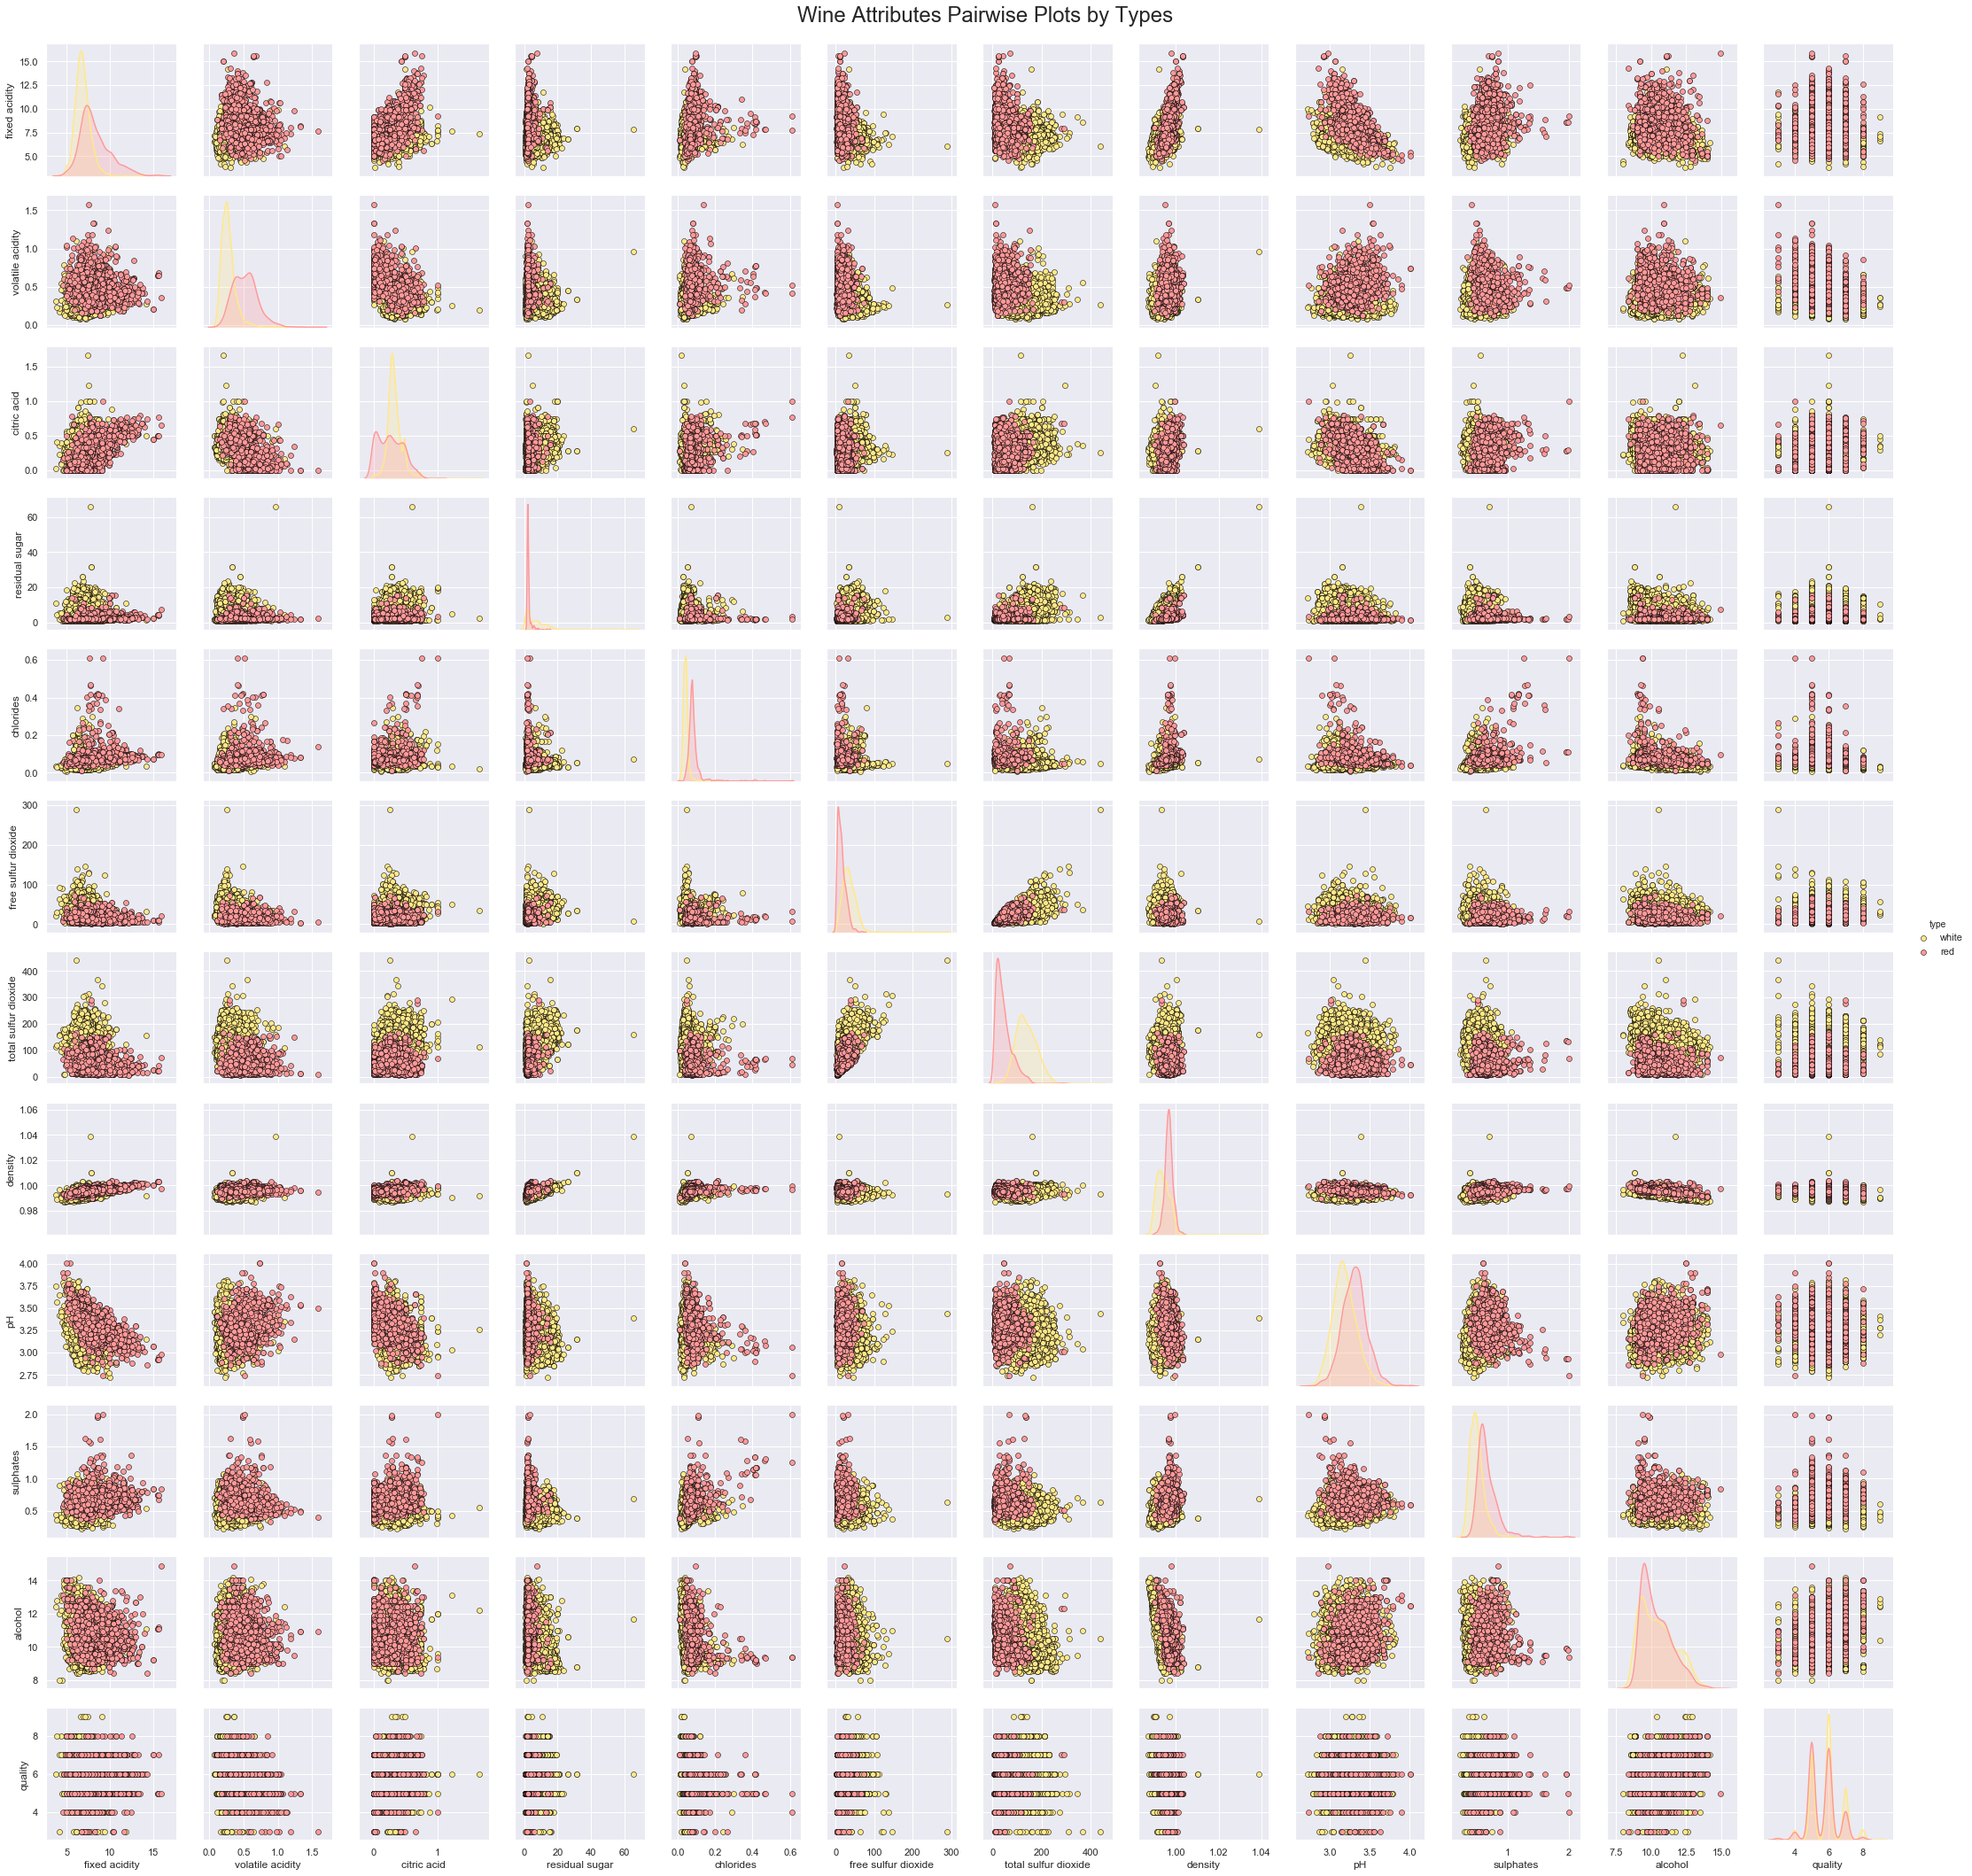

In [15]:
sns.set(font_scale=1.0)
g = sns.pairplot(data = wines, hue='type', palette={'red': '#FF9999', 'white': '#FFE888'},plot_kws=dict(edgecolor='black', linewidth=0.5))
fig = g.fig 
fig.subplots_adjust(top=0.96, wspace=0.2)
t = fig.suptitle('Wine Attributes Pairwise Plots by Types', fontsize=24)

Остаточный сахар, общий диоксид серы и лимонная кислота в белом вине, по-видимому, намного выше, чем в красном.
Сульфаты, фиксированная кислотность и летучая кислотность, по-видимому, выше в красном вине по сравнению с белым вином.
Плотность имеет слабо выраженную отрицательную корреляцию с алкоголем, что подтверждается линейным трендом точек слева направо в убывающем (нисходящем) направлении.
Плотность имеет несколько сильную положительную корреляцию с остаточным сахаром, который усиливается двумя выбросами белого вина.

# 3. Data Preparation

## 3.1 Категориальные переменные должны быть преобразованы в числовые переменные



In [13]:

class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(wines.type.values) # 1 - White; 0 - Red
wines['color'] = y_tp


## 3.2 Заполнить пропущенные значения в переменных
Большинство алгоритмов машинного обучения требуют, чтобы все переменные имели значения, чтобы использовать их для обучения модели. Самый простой метод - заполнить пропущенные значения средним по переменной для всех наблюдений в обучающем наборе.

In [14]:
# Т.к. у нас незначительное количество пропущенных данных, удалим их
wines.dropna(inplace=True)

## 3.3 Исследование выбросов

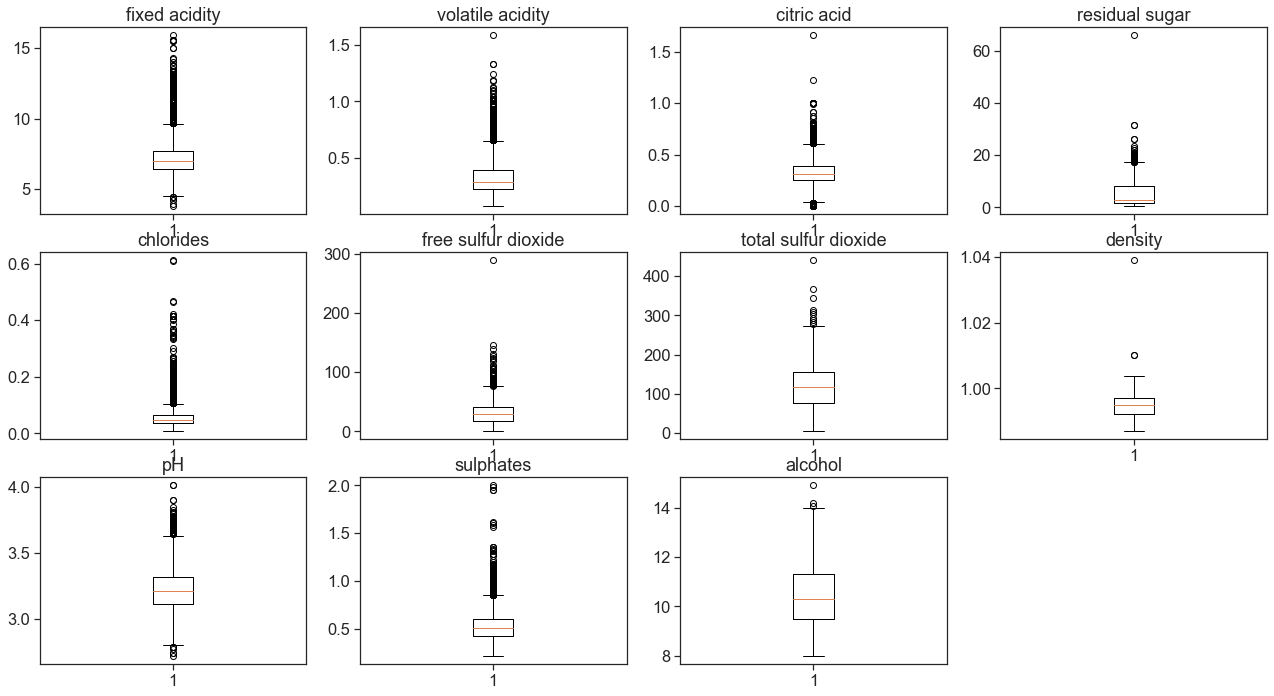

In [33]:
outliers_by_12_variables = ['fixed acidity', 'volatile acidity', 'citric acid',
                            'residual sugar', 'chlorides', 'free sulfur dioxide',
                            'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'] 
plt.figure(figsize=(22,20))

for i in range(0,11):
    plt.subplot(5, 4, i+1)
    plt.boxplot(wines[outliers_by_12_variables[i]])
    plt.title(outliers_by_12_variables[i])

## 3.3 Feature Engineering


## 3.4 Сборка финальных датасетов для моделирования

### 3.4.1 Variable selection


In [15]:
X = wines[['fixed acidity', 'volatile acidity', 'citric acid',
                            'residual sugar', 'chlorides', 'free sulfur dioxide',
                            'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'] ] 
y = wines.quality_label

X.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9


### 3.4.2 Создание датасетов

Отделяем данные для обучения и для проверки

In [16]:
# Create all datasets that are necessary to train, validate and test models
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=40)


### 3.4.3 Важность признаков
Отбор оптимальных признаков для модели имеет важное значение. Теперь мы попытаемся оценить, какие переменные являются наиболее важными, чтобы сделать прогноз.

1.0


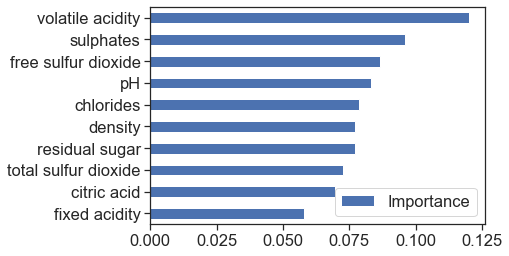

In [17]:
def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
        
plot_variable_importance(X_train, y_train)

# 4. Моделирование
Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

## 4.1 Выбор модели
Хорошей отправной точкой является логистическая регрессия.

In [18]:
model = LogisticRegression()

## 4.2 Обучение модели

In [19]:
model.fit( X_train , y_train )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# 5. Оценка
Теперь мы собираемся оценить модель

## 5.1 Модель
Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [51]:
# Score the model
print (model.score( X_train , y_train ) , model.score( X_test , y_test ))

0.6804642166344294 0.6821345707656613


In [56]:
from sklearn.metrics import classification_report, precision_recall_fscore_support
y_pred = model.predict( X_test )
print(classification_report(y_test,y_pred))



              precision    recall  f1-score   support

        high       0.00      0.00      0.00        31
         low       0.62      0.51      0.56       470
      medium       0.71      0.81      0.76       792

    accuracy                           0.68      1293
   macro avg       0.44      0.44      0.44      1293
weighted avg       0.66      0.68      0.67      1293



# 6. Развертывание



In [20]:
import pickle

In [22]:
pickle.dump(model, open('wine_model.sav', 'wb'))